In [2]:
import csv
from collections import defaultdict, Counter
import pandas
import re
import matplotlib.pyplot as plt

In [3]:
from collections import namedtuple
import csv
import pathlib
import re
GTFRecord = namedtuple('GTFRecord',('seqname','source','feature','start','end','score','strand','frame','attr'))
class GTFParser(object) :
    attr_split_re = re.compile('([a-zA-Z_]+) "([^"]+)";')
    def __init__(self,f) :
        self._path_in = False
        if isinstance(f, str) or isinstance(f, pathlib.Path):
            self._path_in = True
            self._f = open(f)
        else :
            self._f = f
    def parse_attrs(attr) :
        attr_d = {}
        for at in GTFParser.attr_split_re.findall(attr) :
            k, v = at
            if len(at) == 0 : continue
            attr_d[k] = v.lstrip('\'"').strip('\'"')
        return attr_d
    def records(self) :
        for r in csv.reader(self._f,delimiter='\t') :
            # replace any . with None
            r = [_ if _ != '.' else None for _ in r]
            r[-1] = GTFParser.parse_attrs(r[-1])
            yield GTFRecord(*r)
    def __enter__(self):
        return self.records()
    def __exit__(self, type, value, traceback):
        if self._path_in :
            self._f.close()

In [4]:
taxclass_patt = re.compile('taxclass "([^"]*)"')
gene_stats = []
transcript_stats = []
gene_site = defaultdict(set)

with GTFParser('Holobiont_transcripts_hits.gtf') as f :
    for r in f :
        taxclass = r.attr.get('taxclass')
        if taxclass is None :
            taxclass = 'nohit'
        tid = r.attr.get('transcript_id')
        taxids = r.attr.get('taxa_ids')
        site = tid[5:7] if tid else None
        d = {
                'gid': r.seqname,
                'site': site,
                'source': r.source,
                'taxclass': taxclass,
                'taxids': taxids
            }
        if r.feature == 'gene' :
            gene_stats.append(d)
        if r.feature == 'transcript' :
            transcript_stats.append(d)
            gene_site[d['gid']].add(d['site'])

gene_stats = pandas.DataFrame(gene_stats)
gene_stats.index = gene_stats.gid
transcript_stats = pandas.DataFrame(transcript_stats)

In [5]:
# set the site variable in gene_stats based on transcript stats
gene_stats['site'] = gene_stats.gid.apply(lambda x: list(gene_site[x])[0] if len(gene_site.get(x)) != 2 else 'Both')

In [6]:
taxmap = {
    'nohit': 'No hit',
    'cni': 'Cnidaria',
    'bacteria': 'Bacteria',
    'smb': 'Symbiodiniaceae',
    'meta_other': 'Other Metazoa',
    'euk_other': 'Other Eukaryota',
    'fungi': 'Fungi',
    'other_seqs': 'Other Sequences',
    'virus': 'Virus',
    'archaea': 'Archaea'
}
gene_stats['Taxonomic Class'] = gene_stats.taxclass.map(taxmap)
transcript_stats['Taxonomic Class'] = transcript_stats.taxclass.map(taxmap)

In [7]:
gene_stats['Taxonomic Class'].value_counts()

No hit             114113
Cnidaria            51423
Bacteria            25716
Symbiodiniaceae     21080
Other Metazoa       19468
Other Eukaryota      6364
Fungi                1060
Other Sequences       383
Virus                 105
Archaea                73
Name: Taxonomic Class, dtype: int64

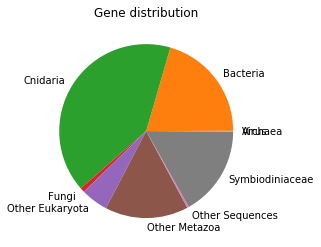

In [8]:
gene_stats.groupby('Taxonomic Class').count().drop(index='No hit').rename(columns={'gid':''})[''].plot.pie(title='Gene distribution')

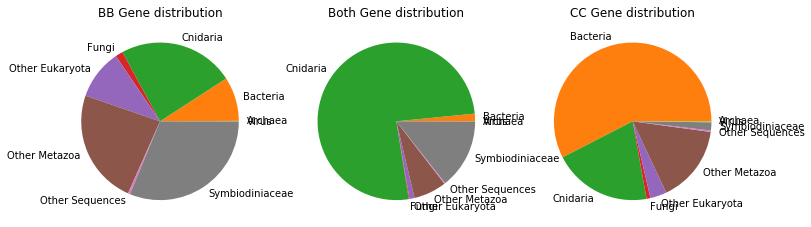

In [9]:
f, axs = plt.subplots(1,3,figsize=(12,4))
f.patch.set_facecolor('white')
for ax, (site, stats) in zip(axs, gene_stats.groupby('site')) :
    stats.groupby('Taxonomic Class').count().drop(index='No hit').rename(columns={'gid':''})[''].plot.pie(title='{} Gene distribution'.format(site),ax=ax)

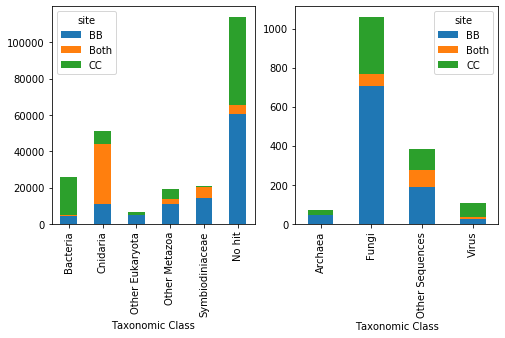

In [10]:
gene_stats_grouped = gene_stats.groupby(['site','Taxonomic Class'])['Taxonomic Class'].count().unstack('site')

f, axs = plt.subplots(1,2,figsize=(8,4))
f.patch.set_facecolor('white')
gene_stats_grouped.loc[['Bacteria','Cnidaria','Other Eukaryota','Other Metazoa','Symbiodiniaceae','No hit']].plot(kind='bar', stacked=True,ax=axs[0])
gene_stats_grouped.loc[['Archaea','Fungi','Other Sequences','Virus']].plot(kind='bar', stacked=True,ax=axs[1])

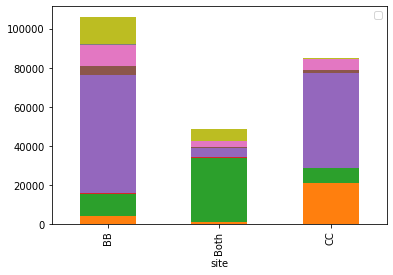

In [11]:
f = gene_stats.groupby(['site','Taxonomic Class'])['site'].count().unstack('Taxonomic Class').plot(kind='bar', stacked=True)
#f.axes.set_yscale('log')
f.legend('')

In [12]:
transcript_stats.taxclass.value_counts()

cni           666346
nohit         153086
smb            94112
bacteria       35959
meta_other     35860
euk_other      12055
org_other       2168
fungi           1679
other_seqs       710
virus            200
archaea          114
Name: taxclass, dtype: int64

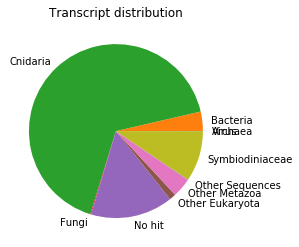

In [13]:
transcript_stats.groupby('Taxonomic Class').count().rename(columns={'gid':''})[''].plot.pie(title='Transcript distribution')

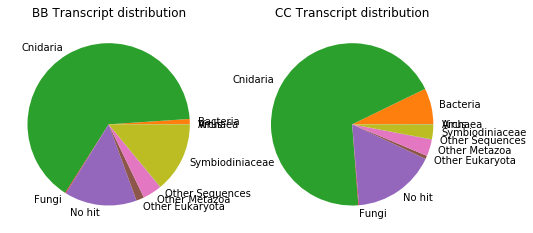

In [14]:
f, axs = plt.subplots(1,2,figsize=(8,4))
f.patch.set_facecolor('white')
for ax, (site, stats) in zip(axs,transcript_stats.groupby('site')) :
    stats.groupby('Taxonomic Class').count().rename(columns={'gid':''})[''].plot.pie(title='{} Transcript distribution'.format(site),ax=ax)

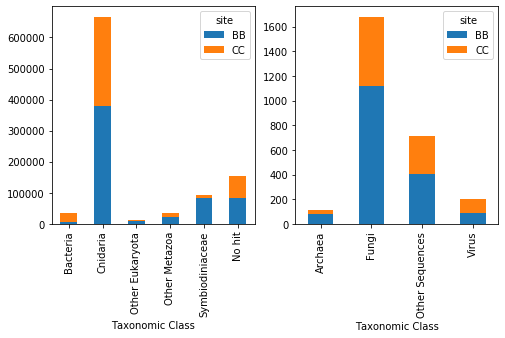

In [15]:
transcript_stats_grouped = transcript_stats.groupby(['site','Taxonomic Class'])['Taxonomic Class'].count().unstack('site')

f, axs = plt.subplots(1,2,figsize=(8,4))
f.patch.set_facecolor('white')
transcript_stats_grouped.loc[['Bacteria','Cnidaria','Other Eukaryota','Other Metazoa','Symbiodiniaceae','No hit']].plot(kind='bar', stacked=True,ax=axs[0])
transcript_stats_grouped.loc[['Archaea','Fungi','Other Sequences','Virus']].plot(kind='bar', stacked=True,ax=axs[1])

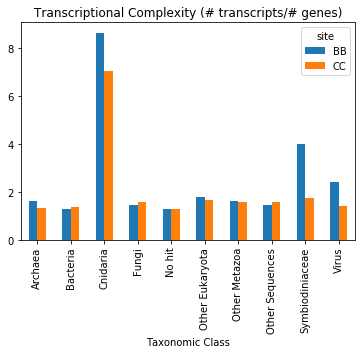

In [16]:
site_gene_stats_grouped = gene_stats_grouped.copy()
site_gene_stats_grouped['BB'] += gene_stats_grouped['Both']
site_gene_stats_grouped['CC'] += gene_stats_grouped['Both']
site_gene_stats_grouped.drop(columns='Both',inplace=True)
f = (transcript_stats_grouped/site_gene_stats_grouped).plot(kind='bar',title='Transcriptional Complexity (# transcripts/# genes)')
f.patch.set_facecolor('white')

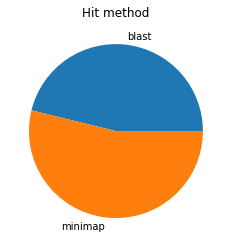

In [17]:
transcript_stats.groupby('source').count().rename(columns={'gid':''})[''].plot.pie(title='Hit method')

In [18]:
transcript_stats

gid site source  \
0        Acer_CC1_Locus_3575_Transcript_49of69_Confiden...   CC   None   
1        Acer_CC1_Locus_3575_Transcript_49of69_Confiden...   CC   None   
2        Acer_CC1_Locus_3575_Transcript_49of69_Confiden...   CC   None   
3        Acer_CC1_Locus_3575_Transcript_49of69_Confiden...   CC   None   
4        Acer_CC1_Locus_3575_Transcript_49of69_Confiden...   CC   None   
...                                                    ...  ...    ...   
1002284                                          114965522   CC  blast   
1002285                                          116050127   BB  blast   
1002286  Acer_BB1_Locus_36063_Transcript_2of4_Confidenc...   BB   None   
1002287  Acer_BB1_Locus_36063_Transcript_2of4_Confidenc...   BB   None   
1002288  Acer_BB1_Locus_36063_Transcript_2of4_Confidenc...   BB   None   

           taxclass  taxids Taxonomic Class  
0             nohit      NA          No hit  
1             nohit      NA          No hit  
2             nohit      NA          No hit  
3             nohit      NA          No hit  
4             nohit      NA          No hit  
...             ...     ...             ...  
1002284         cni   45264        Cnidaria  
1002285  meta_other  283035   Other Metazoa  
1002286       nohit      NA          No hit  
1002287       nohit      NA          No hit  
1002288       nohit      NA          No hit  

[1002289 rows x 6 columns]

Examine phylogenetic breakout of each taxclass by site


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
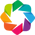

In [19]:
import json
import networkx as nx
from functools import reduce
from itertools import chain
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import holoviews as hv
from holoviews import opts
from IPython.display import display

hv.extension('bokeh')

In [20]:
taxnames = {}
with open('hits/names.dmp') as f :
    for r in csv.reader(f,delimiter='|') :
        r = [_.strip() for _ in r]
        if r[3] == 'scientific name' :
            taxnames[r[0]] = r[1]

In [21]:
g = nx.DiGraph()
with open('hits/nodes.dmp','rt') as f :
    for r in csv.reader(f,delimiter='|') :
        r = [_.strip() for _ in r]
        g.add_edge(r[1],r[0])
        g.nodes[r[1]]['n'] = taxnames[r[1]]
        g.nodes[r[0]]['n'] = taxnames[r[0]]

In [22]:
taxonids = { 
    'cni': '6073',
    'smb': '252141',
    'meta': '33208',
    'euk': '2759',
    'archaea': '2157',
    'fungi': '4751',
    'bacteria': '2',
    'virus': '10239',
    'other_seqs': '28384'
}
with open('subtaxa.json') as f :
    subtaxa = json.load(f)
    for k in subtaxa :
        if k in taxonids :
            subtaxa[k].append(taxonids.get(k))

In [23]:
subgraphs = {}
def reduce_tree(g,nodes) :
    # first get rid of all leaf nodes not in nodes
    print('tree size: {}'.format(len(g)))
    for n in list(g.nodes) :
        if n not in nodes and g.out_degree(n) == 0 :
            g.remove_node(n)
            
    print('tree size after leaf prune: {}'.format(len(g)))
    # find root(s)
    roots = [_ for _ in g.nodes if g.in_degree(_) == 0]
    
    # now remove intermediate nodes that are not in nodes
    for root in roots :
        for n in list(nx.algorithms.dag.descendants(g,root)) :
            if n not in nodes :
                pred = list(g.predecessors(n))
                assert len(pred) == 1
                pred = pred[0]

                for succ in list(g.successors(n)) :
                    g.add_edge(pred,succ)
                    
                g.remove_node(n)
    print('tree size after subset: {}'.format(len(g)))
    
    return g
    

In [24]:
def prune_tree(g,nodes) :
    
    print('tree size: {}'.format(len(g)))
    
    # find the leaves that are not in nodes
    leaves = [_ for _ in g.nodes if g.out_degree(_) == 0 and _ not in nodes]
    
    print('num leaves: {}'.format(len(leaves)))
    
    # prune up leaves until we hit a node in nodes
    while len(leaves) > 0 :
        for leaf in leaves :
            g.remove_node(leaf)    
        leaves = [_ for _ in g.nodes if g.out_degree(_) == 0 and _ not in nodes]
    print('tree size after pruning: {}'.format(len(g)))
    
    return g

defaults = dict(width=1500, height=500)
hv.opts.defaults(
    opts.EdgePaths(**defaults), opts.Graph(**defaults), opts.Nodes(**defaults)
)


stats_d = defaultdict(dict)

layout = 'dot'
taxgraph_figs = {}
for taxclass,nodes in subtaxa.items() :
    print(taxclass)
    #if taxclass != 'org_other' : continue
        
    subgraph = nx.DiGraph(g.subgraph(nodes))
    
    tax_stats = transcript_stats[transcript_stats.taxclass == taxclass]
    
    # cc
    taxids = set(chain(*[_.split(';') for _ in tax_stats[tax_stats.site == 'CC'].taxids if _ is not None]))
    cc_taxids = taxids.difference(['NA',''])
    cc_taxgraph = prune_tree(subgraph.copy(),cc_taxids)
    #cc = hv.Graph.from_networkx(taxgraph, graphviz_layout, prog=layout).opts(tools=['hover'])
    
    # bb
    taxids = set(chain(*[_.split(';') for _ in tax_stats[tax_stats.site == 'BB'].taxids if _ is not None]))
    bb_taxids = taxids.difference(['NA',''])
    bb_taxgraph = prune_tree(subgraph.copy(),bb_taxids)
    #bb = hv.Graph.from_networkx(taxgraph, graphviz_layout, prog=layout).opts(tools=['hover'])
    #break
    
    taxgraph = cc_taxgraph.copy()
    taxgraph.add_nodes_from(bb_taxgraph.nodes)
    taxgraph.add_edges_from(bb_taxgraph.edges)

    
    # add attributes to the graph so we can draw them
    for n in taxgraph.nodes :
        in_cc = n in cc_taxids
        in_bb = n in bb_taxids
        
        site = 'None'
        if in_cc and in_bb :
            site = 'Both'
        elif in_cc :
            site = 'CC'
        elif in_bb :
            site = 'BB'

        taxgraph.nodes[n]['site'] = site
        taxgraph.nodes[n]['n'] = taxnames[n]
        
        stats_d[n].update({
            'taxid': n,
            'taxclass': taxclass,
            'site':site,
            'name': taxnames[n]
        })
        
    # compute 'purity' score based on the difference in number of unique taxa per node
    for n in taxgraph.nodes :
        counts = Counter()
        children = list(nx.algorithms.dag.descendants(taxgraph,n))
        for succ in children :
            counts[taxgraph.nodes[succ]['site']] += 1

        x = counts['CC']-counts['BB']
        max_count = counts['CC']+counts['BB']+counts['Both']
        purity = x/max(max_count,1)
        taxgraph.nodes[n]['purity'] = purity
        
        stats_d[n].update({
            'count_diff': x,
            'max_count': max_count,
            'purity': purity
        })
        stats_d[n].update(**counts)
        
        for k,v in counts.items() :
            taxgraph.nodes[n][k] = v


    gr = hv.Graph.from_networkx(taxgraph, graphviz_layout, prog=layout).opts(tools=['hover'])
    gr.opts(opts.Graph(node_size=10, node_color='site',cmap={'None':'white','CC':'red','BB':'blue','Both':'black'}))
    display(gr)
    taxgraph_figs[taxclass] = gr
    #break

fieldnames = ('taxid','name','taxclass','site','count_diff','max_count','purity','CC','BB','Both','None')
with open('taxgraph_stats.csv','wt') as f :
    f = csv.DictWriter(f,fieldnames=fieldnames)
    f.writeheader()
    f.writerows(stats_d.values())

cni
tree size: 11179
num leaves: 8970
tree size after pruning: 128
tree size: 11179
num leaves: 8960
tree size after pruning: 135


:Graph   [start,end]

smb
tree size: 2725
num leaves: 2644
tree size after pruning: 35
tree size: 2725
num leaves: 2635
tree size after pruning: 48


:Graph   [start,end]

archaea
tree size: 13496
num leaves: 12414
tree size after pruning: 96
tree size: 13496
num leaves: 12404
tree size after pruning: 120


:Graph   [start,end]

fungi
tree size: 166745
num leaves: 152729
tree size after pruning: 785
tree size: 166745
num leaves: 152548
tree size after pruning: 1264


:Graph   [start,end]

bacteria
tree size: 506949
num leaves: 482903
tree size after pruning: 8734
tree size: 506949
num leaves: 486144
tree size after pruning: 4741


:Graph   [start,end]

virus
tree size: 205663
num leaves: 199320
tree size after pruning: 138
tree size: 205663
num leaves: 199346
tree size after pruning: 74


:Graph   [start,end]

other_seqs
tree size: 15594
num leaves: 15521
tree size after pruning: 64
tree size: 15594
num leaves: 15531
tree size after pruning: 54


:Graph   [start,end]

meta_other
tree size: 1033042
num leaves: 921005
tree size after pruning: 2929
tree size: 1033042
num leaves: 920998
tree size after pruning: 2863


:Graph   [start,end]

euk_other
tree size: 271568
num leaves: 232052
tree size after pruning: 1288
tree size: 271568
num leaves: 232011
tree size after pruning: 1419


:Graph   [start,end]

org_other
tree size: 975
num leaves: 959
tree size after pruning: 5
tree size: 975
num leaves: 959
tree size after pruning: 4


:Graph   [start,end]

In [40]:
taxgraph.nodes['48498']

{'site': 'Both'}